In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


[*********************100%***********************]  1 of 1 completed


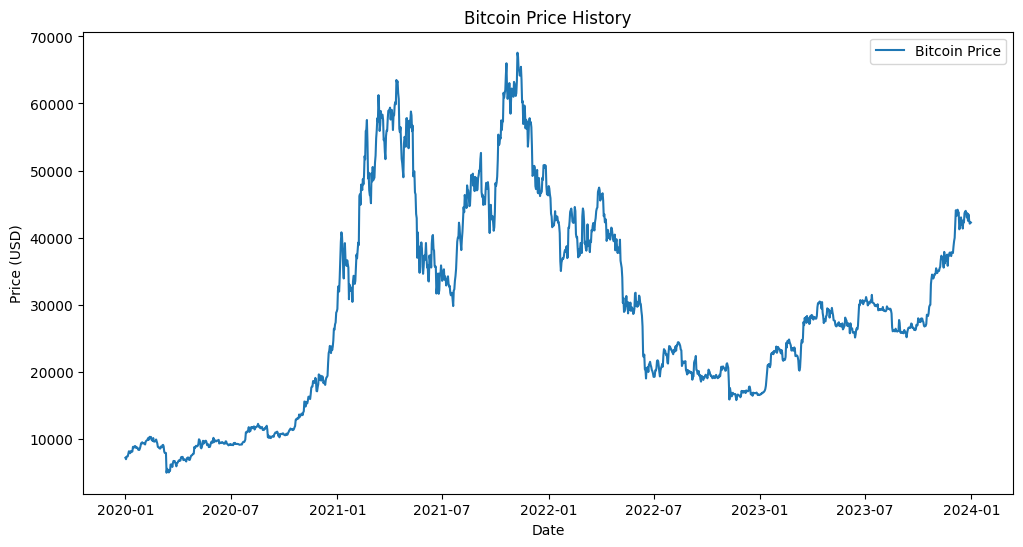

In [2]:
# Download Bitcoin price data from Yahoo Finance
df = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01')

# Keep only the 'Close' price
df = df[['Close']]

# Plot the data
plt.figure(figsize=(12,6))
plt.plot(df, label='Bitcoin Price')
plt.title("Bitcoin Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


Step 4: Preprocess Data for LSTM:
LSTMs need normalized data and sequences:

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

# Convert data to sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Use the past 60 days to predict the next day
X, y = create_sequences(df_scaled, SEQ_LENGTH)

# Split into train & test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


Step 5: Build the LSTM Model :

Now, we define a simple LSTM model:

---



In [4]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Step 6: Train the Model

Now, train the LSTM model:

In [5]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0573 - val_loss: 0.0017
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0065 - val_loss: 5.6953e-04
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0040 - val_loss: 6.1732e-04
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0041 - val_loss: 8.7676e-04
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0042 - val_loss: 4.7701e-04
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0036 - val_loss: 4.4367e-04
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0030 - val_loss: 7.2692e-04
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0027 - val_loss: 4.4638e-04
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0026 - val_loss: 3.9386e-04
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0029 - val_loss: 3.8126e-04
Epoch 12/20
35/35 ━━━━━━━

Step 7: Evaluate & Predict

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


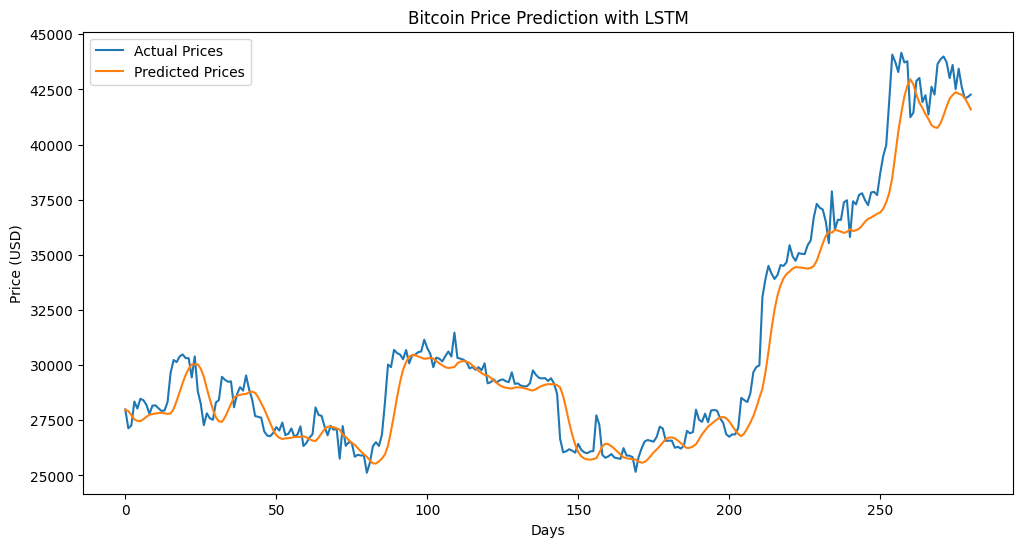

In [6]:
# Predict on test data
y_pred = model.predict(X_test)

# Rescale back to original values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.title("Bitcoin Price Prediction with LSTM")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [7]:
# Get the last 60 days from the dataset
last_60_days = df_scaled[-SEQ_LENGTH:]  # The last 60 days of data
last_60_days = np.array([last_60_days])  # Reshape for LSTM input

In [8]:
# Predict the next day's price
predicted_price = model.predict(last_60_days)

# Convert back to actual price
predicted_price = scaler.inverse_transform(predicted_price)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


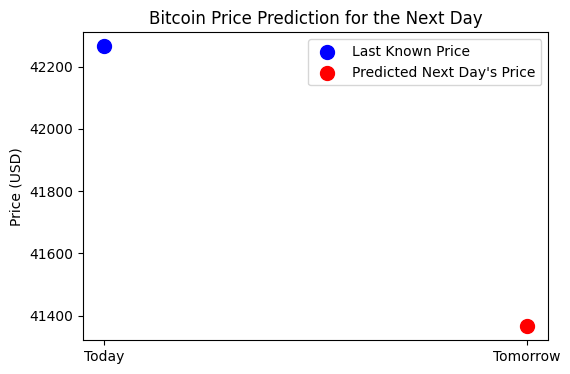

In [10]:
# Get the actual last known price
actual_last_price = df['Close'].iloc[-1]  # Last recorded price in dataset

# Plot
plt.figure(figsize=(6,4))
plt.scatter([0], [actual_last_price], color='blue', label="Last Known Price", s=100)
plt.scatter([1], [predicted_price[0][0]], color='red', label="Predicted Next Day's Price", s=100)
plt.xticks([0, 1], ["Today", "Tomorrow"])
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Prediction for the Next Day")
plt.legend()
plt.show()
